In [1]:
%cd /home/m19c96/ml_reg/w_plots/coral


/home/m19c96/ml_reg/w_plots/coral


/home/m19c96/miniconda3/envs/dl/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
from pathlib import Path
import pandas as pd

res = []
missing = []
#TU_IOT_to_Office
#IOT_Office_to_TU
base = Path("TU_Office_to_IOT")

for i in range(100):
    file_path = base / f"trial_{i:03d}" / "range_metrics_summary.csv"
    if not file_path.exists():
        missing.append(str(file_path))
        continue
    temp = pd.read_csv(file_path)
    temp.columns = [c.strip() for c in temp.columns]  # avoid whitespace-mismatch columns
    temp["id"] = i
    res.append(temp)

final_df = pd.concat(res, ignore_index=True) if res else pd.DataFrame()
print("loaded rows:", len(final_df), "missing files:", len(missing))
print("columns:", list(final_df.columns))

## Why a reconstruction loss can appear as 0 (quick checks)
- The column isn’t present (or has a slightly different name / trailing spaces) so you’re looking at a different metric.
- It was serialized/rounded to 0 in `range_metrics_summary.csv` (e.g., very small values + low precision).
- It’s a string column like `'0'` or `'0.0000'` (pandas shows it, but math behaves oddly until cast).
- It’s genuinely constant because the loss wasn’t computed/updated (e.g., logged before forward pass, always multiplied by 0, empty batch, etc.).

The cell below auto-finds loss-like columns and summarizes them.

In [ ]:
import numpy as np

if final_df.empty:
    raise ValueError("final_df is empty — check 'base' path and trial files.")

# auto-detect likely loss columns
loss_cols = [c for c in final_df.columns if any(k in c.lower() for k in ["recon", "reconstruction", "loss"]) ]
print("candidate loss columns:", loss_cols)

for c in loss_cols:
    s = final_df[c]
    print("\n==", c, "==")
    print("dtype:", s.dtype)
    # try numeric view to catch strings/objects
    sn = pd.to_numeric(s, errors="coerce")
    print("numeric NaNs:", int(sn.isna().sum()), "/", len(sn))
    print("min/max (numeric):", float(np.nanmin(sn)), float(np.nanmax(sn)))
    print("unique (top 10):", sn.value_counts(dropna=False).head(10).to_dict())
    if "split" in final_df.columns:
        print("per-split min/max:")
        print(final_df.assign(_v=sn).groupby("split")["_v"].agg(["count", "min", "max"]))
    nz = final_df.loc[sn.fillna(0) != 0, ["id"] + (["split"] if "split" in final_df.columns else []) + [c]].head(10)
    print("nonzero rows (head):")
    print(nz if len(nz) else "<none>")

## Keras log shows `recon_loss: 0.0000e+00` (what to check)
If it prints `0.0000e+00`, it’s usually exactly zero.

Most common root causes:
- **Wrong targets**: `y_recon_true` is the same tensor as the model output, or it’s all zeros/constant.
- **Wrong wiring**: output name in `compile(loss={...})` doesn’t match the recon head name, so you’re tracking a different/empty loss.
- **Masking/weighting to zero** inside the recon loss function (or sample weights are all 0 for that output).

Use the snippet below (run where you have access to `model` and a dataset) to confirm target/pred stats and the raw recon error on one batch.

In [ ]:
# Template snippet (run in your training environment where `model` and `train_ds` exist)
# Edit the keys/names to match your setup (e.g., dict outputs like {"recon": ..., "task": ...}).

import tensorflow as tf

# batch = next(iter(train_ds))
# x, y = batch  # or (x, y, sample_weight) depending on your pipeline

# y_true_recon = y["recon"]  # <-- change to your recon target
# y_pred = model(x, training=False)
# y_pred_recon = y_pred["recon"] if isinstance(y_pred, dict) else y_pred  # <-- change if needed

# print("y_true_recon min/max:", float(tf.reduce_min(y_true_recon)), float(tf.reduce_max(y_true_recon)))
# print("y_pred_recon min/max:", float(tf.reduce_min(y_pred_recon)), float(tf.reduce_max(y_pred_recon)))
# raw_mse = tf.reduce_mean(tf.square(tf.cast(y_true_recon, tf.float32) - tf.cast(y_pred_recon, tf.float32)))
# print("raw recon MSE on this batch:", float(raw_mse))

# If raw_mse is exactly 0.0, dump a small slice to see if tensors are literally identical:
# print("allclose:", bool(tf.reduce_all(tf.equal(y_true_recon, y_pred_recon))))

In [3]:
from pathlib import Path
print(Path.cwd())


/home/m19c96/ml_reg/w_plots/coral


In [4]:
df=final_df[final_df["split"]=="test_adaption"]

<Axes: ylabel='Frequency'>

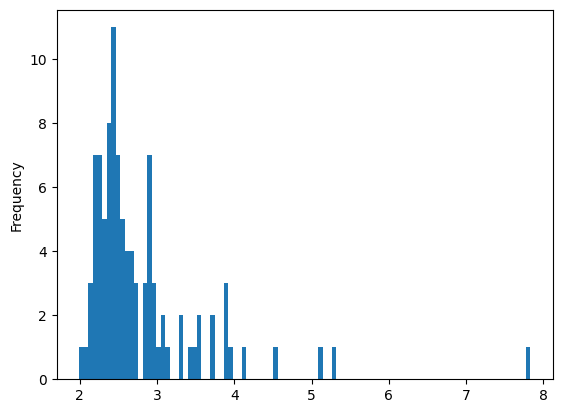

In [5]:
df["MAE(camera, predicted_rng)"].plot.hist(bins=100)

In [6]:
print("minimum of the error", df["MAE(camera, predicted_rng)"].min())
print("test-adaption", df[df["split"]=="test_adaption"]["MAE(camera, sensor)"].head(1))



minimum of the error 1.9948495626449585
test-adaption 1    2.036859
Name: MAE(camera, sensor), dtype: float64


In [7]:
final_df.head(10)

,split,N,"MAE(camera, sensor)","MSE(camera, sensor)","MAE(camera, predicted_rng)","MSE(camera, predicted_rng)",MAE_improvement_%,MSE_improvement_%,id
0,ADAPTION,14000,1.909578,10.770617,3.343075,21.402719,-75.068759,-98.713950,0
1,test_adaption,21085,2.036859,11.890612,3.283205,20.974962,-61.189636,-76.399355,0
2,TEST,2000,1.936917,10.734470,3.348752,22.270899,-72.890775,-107.470868,0
3,ADAPTION,14000,1.909578,10.770617,3.696379,24.980526,-93.570417,-131.932162,1
4,test_adaption,21085,2.036859,11.890612,3.712158,25.249342,-82.249144,-112.346873,1
5,TEST,2000,1.936917,10.734470,3.697221,24.998550,-90.881695,-132.881079,1
6,ADAPTION,14000,1.909578,10.770617,2.871418,15.835097,-50.369234,-47.021258,2
7,test_adaption,21085,2.036859,11.890612,2.882064,16.238117,-41.495539,-36.562506,2
8,TEST,2000,1.936917,10.734470,2.807674,15.239825,-44.955789,-41.970910,2
9,ADAPTION,14000,1.909578,10.770617,3.658221,28.268875,-91.572178,-162.462901,3
